# Dataset1: Wine-Quality-Data-Set 


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [39]:
def read_file(path):
    rawdata = pd.read_excel(path)
    return rawdata

In [40]:
# Function for standardizing data
def standardScaler(feature_array):
    num = feature_array.shape[1] # total number of columns
    for i in range(num): # iterating through each column
        feature = feature_array[:, i]
        mean = feature.mean() # mean stores mean value for the column
        std = feature.std() # std stores standard deviation value for the column
        feature_array[:, i] = (feature_array[:, i] - mean) / std # standard scaling of each element of the column
    return feature_array


## Dicision Tree

In [41]:
def entropy(x):
    '''
    calculates entropy of x
    
    input_ : x (a list of values)
    output : float, entropy value
    '''
    counts = np.bincount(np.array(x, dtype=np.int64))
    percentages = counts / len(x)

    # Caclulate entropy

    entropy = 0
    for p in percentages:
        if p > 0:
            entropy += p * np.log2(p)
    entropy = -entropy
    return entropy

In [42]:
def information_gain(parent, left_child, right_child):
    '''
    calculates information gain of a node  
    
    input_ : parent_list, child_list (left child and right child)
    output : float, information gain value
    '''
    left_num = len(left_child) / len(parent)
    right_num = len(right_child) / len(parent)

    child = left_num * entropy(left_child) + right_num * entropy(right_child)
    
    return entropy(parent) - child

In [43]:
class Node:
    '''
    define the node in the decistion tree
    
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

In [44]:
class DecisionTree:
    '''
    implementing decisicion tree  
    
    '''
    def __init__(self, min_samples_split=2, max_depth=7):
      self.min_samples_split = min_samples_split
      self.max_depth = max_depth
      self.root = None
      
    def _best_split(self, X, y):
      '''
      calculates the best split for given features and target  
      
      input_ : X = features, y = target 
      output : best_split (dict)
      '''
      best_split = {}
      best_info_gain = -1
      n_rows, n_cols = X.shape
      
      # For every dataset feature
      for f_idx in range(n_cols):
          X_curr = X[:, f_idx]
          # For every unique value of that feature
          for threshold in np.unique(X_curr):
              # Construct a dataset and split it to the left and right parts
              # Left part includes records lower or equal to the threshold
              # Right part includes records higher than the threshold
              df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
              df_left = np.array([row for row in df if row[f_idx] <= threshold])
              df_right = np.array([row for row in df if row[f_idx] > threshold])

              # check if data in the subset
              if len(df_left) <= 0:
                continue
              if len(df_right) <= 0:
                continue

              # Obtain the value of the target variable for subsets
              y = df[:, -1]
              y_left = df_left[:, -1]
              y_right = df_right[:, -1]

              # Caclulate the information gain and save the split parameters
              # if the current split if better then the previous best
              gain = information_gain(y, y_left, y_right)
              if gain > best_info_gain:
                  best_split = {
                      'feature_index': f_idx,
                      'threshold': threshold,
                      'df_left': df_left,
                      'df_right': df_right,
                      'gain': gain
                  }
                  best_info_gain = gain
      return best_split
  
    def _build(self, X, y, depth=0):
      '''
      build a decision tree   
      
      input_ : X = features, y = target, depth 
      output : node
      '''
      n_rows, n_cols = X.shape
      
      # Check to see if a node should be leaf node
      if n_rows >= self.min_samples_split and depth <= self.max_depth:
          # Get the best split
          best = self._best_split(X, y)
          # If the split isn't pure
          if best['gain'] > 0:
              # Build a tree on the left
              left = self._build(
                  X=best['df_left'][:, :-1], 
                  y=best['df_left'][:, -1], 
                  depth=depth + 1
              )
              right = self._build(
                  X=best['df_right'][:, :-1], 
                  y=best['df_right'][:, -1], 
                  depth=depth + 1
              )
              return Node(
                  feature=best['feature_index'], 
                  threshold=best['threshold'], 
                  data_left=left, 
                  data_right=right, 
                  gain=best['gain']
              )
      # Leaf node - value is the most common target value 
      return Node(
          value=Counter(y).most_common(1)[0][0]
      )
  
    def fit(self, X, y):
      '''
      Train with given features and target  
      
      input_ : X = features, y = target 
      output : //
      '''
      # Call a recursive function to build the tree
      self.root = self._build(X, y)
      
    def _predict(self, x, tree):
      '''
      classify a single test data  
      
      input_ : x (one input data)
      output : class (prediction)
      '''
      # Leaf node
      if tree.value != None:
          return tree.value
      feature_value = x[tree.feature]
      
      # classification
      if feature_value <= tree.threshold:
        return self._predict(x=x, tree=tree.data_left)
    
      else:
        return self._predict(x=x, tree=tree.data_right)
      
    def predict(self, testing_data):
      '''
      classify all data
      
      :param X: np.array, features
      :return: np.array, predicted classes
      '''
      # Call the _predict() function for every observation
      return [self._predict(entry, self.root) for entry in testing_data]

## Connect google drive and Import training data and testing data


In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# read_file(path): trianing_data features, trianing_data target, testing_data features 
train_x = read_file('/content/drive/MyDrive/ml_hw/Dataset1_train/train/X_train.xlsx') 
train_y = read_file('/content/drive/MyDrive/ml_hw/Dataset1_train/train/y_train.xlsx')
test_x = read_file('/content/drive/MyDrive/ml_hw/Dataset1_test/X_test.xlsx')

## Data observation


- check if data set with null values(NAN)

In [59]:
temp_df = train_x.isnull().sum().reset_index()
temp_df['Percentage of Null Values'] = temp_df[0]/len(train_x)*100
temp_df.columns = ['Column Name', 'Number of Null Values','Percentage of Null Values']
temp_df

,Column Name,Number of Null Values,Percentage of Null Values
0,fixed_acidity,65,6.353861
1,volatile_acidity,44,4.301075
2,citric_acid,60,5.865103
3,residual_sugar,39,3.812317
4,chlorides,52,5.083089
5,free_sulfur_dioxide,57,5.571848
6,total_sulfur_dioxide,45,4.398827
7,density,46,4.496579
8,pH,58,5.669599
9,sulphates,51,4.985337


In [60]:
train_x.info()
train_x.head(n = 10).style.background_gradient(cmap = "Purples_r")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         958 non-null    float64
 1   volatile_acidity      979 non-null    float64
 2   citric_acid           963 non-null    float64
 3   residual_sugar        984 non-null    float64
 4   chlorides             971 non-null    float64
 5   free_sulfur_dioxide   966 non-null    float64
 6   total_sulfur_dioxide  978 non-null    float64
 7   density               977 non-null    float64
 8   pH                    965 non-null    float64
 9   sulphates             972 non-null    float64
 10  alcohol               965 non-null    float64
dtypes: float64(11)
memory usage: 88.0 KB


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.000000,0.230000,0.400000,1.600000,0.063000,nan,67.000000,0.995200,3.500000,0.630000,11.100000
1,7.800000,0.600000,0.260000,2.000000,0.080000,31.000000,131.000000,0.996220,nan,0.520000,9.900000
2,9.700000,0.690000,0.320000,2.500000,0.088000,22.000000,91.000000,0.997900,3.290000,0.620000,10.100000
3,12.000000,0.380000,0.560000,2.100000,0.093000,6.000000,24.000000,0.999250,3.140000,0.710000,10.900000
4,6.400000,0.640000,0.210000,1.800000,0.081000,14.000000,31.000000,0.996890,3.590000,0.660000,nan
5,7.400000,0.350000,0.330000,2.400000,0.068000,9.000000,26.000000,0.994700,nan,0.600000,11.900000
6,6.900000,0.360000,0.250000,2.400000,0.098000,5.000000,16.000000,0.996400,3.410000,0.600000,10.100000
7,7.500000,0.420000,0.310000,1.600000,0.080000,nan,42.000000,0.997800,3.310000,0.640000,9.000000
8,7.000000,0.745000,0.120000,1.800000,0.114000,nan,64.000000,0.995880,3.220000,0.590000,9.500000
9,6.900000,0.540000,0.040000,3.000000,0.077000,7.000000,27.000000,0.998700,3.690000,0.910000,9.400000


- The distribution of different features

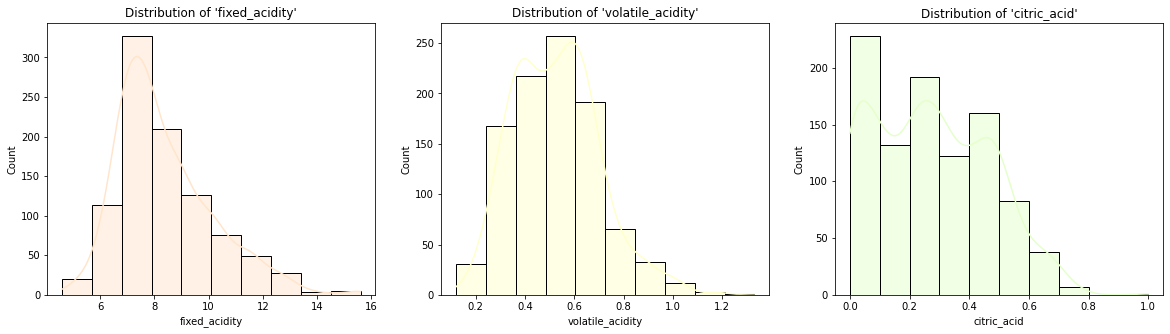

In [64]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))

sns.histplot(ax = axes[0], x = train_x["fixed_acidity"],
             bins = 10,
             kde = True,
             cbar = True,
             color = "#FFE5CC").set(title = "Distribution of 'fixed_acidity'");

sns.histplot(ax = axes[1], x = train_x["volatile_acidity"],
             bins = 10,
             cbar = True,
             kde = True,
             color = "#FFFFCC").set(title = "Distribution of 'volatile_acidity'");

sns.histplot(ax = axes[2], x = train_x["citric_acid"],
             bins = 10,
             kde = True,   
             cbar = True,
             color = "#E5FFCC").set(title = "Distribution of 'citric_acid'");

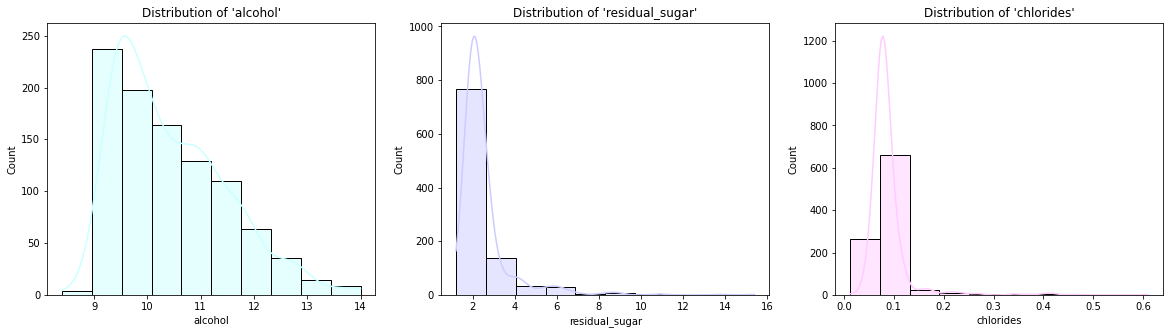

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.histplot(ax = axes[0], x = train_x["alcohol"],
             bins = 10,    
             kde = True,
             cbar = True,
             color = "#CCFFFF").set(title = "Distribution of 'alcohol'");

sns.histplot(ax = axes[1], x = train_x["residual_sugar"],
             bins = 10,
             kde = True,
             cbar = True,
             color = "#CCCCFF").set(title = "Distribution of 'residual_sugar'");

sns.histplot(ax = axes[2], x = train_x["chlorides"],
             bins = 10,
             kde = True,   
             cbar = True,
             color = "#FFCCFF").set(title = "Distribution of 'chlorides'");

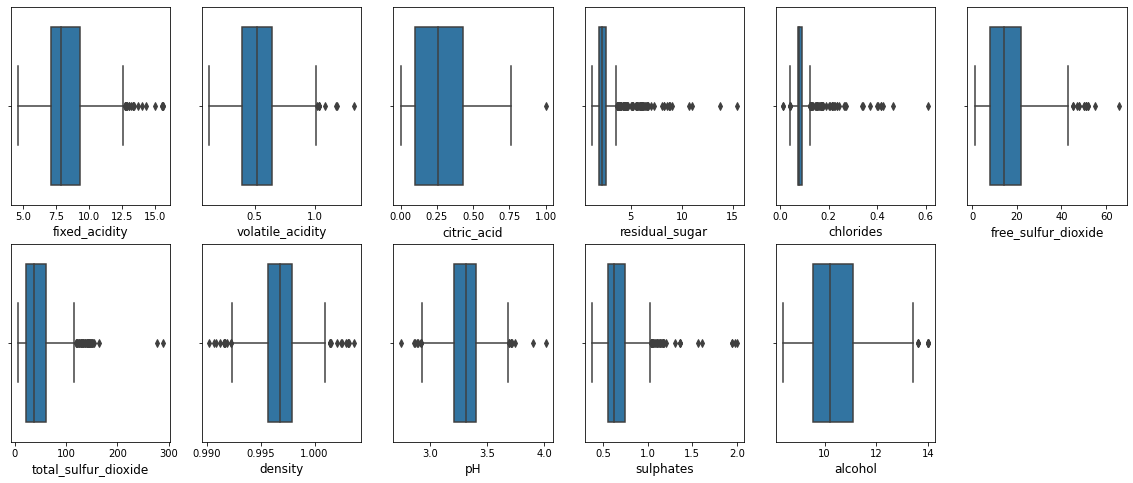

In [73]:
# Checking for outliers
plt.figure(figsize = (20, 8))
for i in range (len(train_x.columns)):
    plt.subplot(2, 6, i+1)
    sns.boxplot(x = train_x.iloc[:, i])
    plt.xlabel(train_x.columns[i], size = 12)

## Deal with missing data

In [49]:
for feature in train_x:
  train_x[feature] = train_x[feature].fillna((train_x[feature].mean()))

In [50]:
for feature in test_x:
  test_x[feature] = test_x[feature].fillna((test_x[feature].mean()))

## Turn the input data to suitable datatye

In [51]:
features = train_x.to_numpy()
target = train_y['class'].to_numpy()
features_test = test_x.to_numpy()

In [52]:
features_scaled = standardScaler(features) 
testfeat_scaled = standardScaler(features_test) 

In [53]:
X_train = np.array(features_scaled)
y_train = np.array(target)
X_test = np.array(testfeat_scaled)
X_train.shape, y_train.shape, X_test.shape


((1023, 11), (1023,), (256, 11))

## Train with decision tree

In [54]:
model = DecisionTree()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [55]:
df = pd.DataFrame(np.array(preds))
df.to_excel("Dataset1_pred.xlsx")